In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
%matplotlib inline
df = pd.read_csv("velo.csv", sep = ";")

In [35]:
# Si erreur on peut reprendre à partir d'ici

df_clean = df.drop(["Lien vers photo du site de comptage", 
              "Identifiant technique compteur", 
              "ID Photos", 
              "test_lien_vers_photos_du_site_de_comptage_", 
              "id_photo_1", 
              "url_sites", 
              "type_dimage",
             "Date d'installation du site de comptage", 
              "Identifiant du compteur", 
              "Identifiant du site de comptage",
             "Nom du site de comptage",
             "Coordonnées géographiques"], axis = 1)

In [7]:
df_clean["Nom du compteur"].nunique()

106

In [36]:
# Convertir la colonne en datetime (avec gestion du fuseau horaire)

df_clean["Date et heure de comptage"] = pd.to_datetime(df_clean["Date et heure de comptage"], utc=True)
df_clean["Date et heure de comptage"] = df_clean["Date et heure de comptage"].dt.tz_localize(None)
#Met les dates dans l'ordre croissant
df_clean = df_clean.sort_values(by="Date et heure de comptage")

In [37]:
# Pour suprimer les lignes se référant à l'année 2022 :
df_clean = df_clean.drop(df_clean[df_clean["Date et heure de comptage"].dt.year == 2022].index)

In [38]:
#Crée 4 colonnes Année, Jour, Mois et Heure 
#Ensuite on range dans l'ordre Heure Jour Mois et Année
df_clean["Jour"] = df_clean["Date et heure de comptage"].dt.day
df_clean["Année"] = df_clean["mois_annee_comptage"].str[:4].astype(int)
df_clean["Mois"] = df_clean["mois_annee_comptage"].str[5:7].astype(int)
df_clean = df_clean.drop(columns=["mois_annee_comptage"])
df_clean["Heure"] = df_clean["Date et heure de comptage"].dt.hour
df_clean["Jour_semaine"] = df_clean["Date et heure de comptage"].dt.weekday + 1
df_clean["Week-end"] = (df_clean["Jour_semaine"] >= 5).astype(int)
df_clean.insert(3, "Jour", df_clean.pop("Jour"))
df_clean.insert(4, "Mois", df_clean.pop("Mois"))
df_clean.insert(5, "Année", df_clean.pop("Année"))
df_clean.insert(6, "Heure", df_clean.pop("Heure"))

In [41]:
df_clean.head()

,Nom du compteur,Comptage horaire,Date et heure de comptage,Jour,Mois,Année,Heure,Jour_semaine,Week-end,Jour férié,Vacances scolaires
662861,38 rue Turbigo SO-NE,46,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
88912,Voie Georges Pompidou NE-SO,11,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
400941,Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli ...,51,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
623168,Face au 40 quai D'Issy SO-NE,4,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
392287,243 boulevard Saint Germain NO-SE,16,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1


In [39]:
# Création manuelle des jours fériés en France pour 2024 et 2025
jours_feries_france = [
    "2024-01-01", "2024-04-01", "2024-05-01", "2024-05-08", "2024-05-09", "2024-05-20",
    "2024-07-14", "2024-08-15", "2024-11-01", "2024-11-11", "2024-12-25",
    "2025-01-01"
]
jours_feries_france = pd.to_datetime(jours_feries_france)

# Ajout de la colonne "Jour férié" (1 si jour férié, 0 sinon)
df_clean["Jour férié"] = df_clean["Date et heure de comptage"].dt.date.isin(jours_feries_france.date).astype(int)



In [40]:
# Définition des périodes de vacances scolaires
vacances = [
    ("2024-01-01", "2024-01-08"),
    ("2024-02-10", "2024-02-26"),
    ("2024-04-06", "2024-04-22"),
    ("2024-05-08", "2024-05-13"),
    ("2024-07-06", "2024-09-02"),
    ("2024-10-19", "2024-11-04"),
    ("2024-12-21", "2025-01-06"),
]

# Création d'un ensemble de dates correspondant aux vacances
dates_vacances = set()
for debut, fin in vacances:
    dates_vacances.update(pd.date_range(start=debut, end=fin))

# Conversion en un objet Pandas Index pour une recherche rapide
dates_vacances = pd.Index(dates_vacances)

# Vérification d'appartenance
df_clean["Vacances scolaires"] = df_clean["Date et heure de comptage"].dt.normalize().isin(dates_vacances).astype(int)

In [42]:
from sklearn.preprocessing import LabelEncoder

df_clean["Nom du compteur"] = LabelEncoder().fit_transform(df_clean["Nom du compteur"])

# Met les compteurs de 0 à 105 = 106 compteurs qui est le nombre obtenu 
# après la suppression de l'année 2022.

In [43]:
df_clean.head()

,Nom du compteur,Comptage horaire,Date et heure de comptage,Jour,Mois,Année,Heure,Jour_semaine,Week-end,Jour férié,Vacances scolaires
662861,33,46,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
88912,104,11,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
400941,96,51,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
623168,67,4,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
392287,19,16,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1


In [44]:
display(df_clean)

,Nom du compteur,Comptage horaire,Date et heure de comptage,Jour,Mois,Année,Heure,Jour_semaine,Week-end,Jour férié,Vacances scolaires
662861,33,46,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
88912,104,11,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
400941,96,51,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
623168,67,4,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
392287,19,16,2024-01-01 03:00:00,1,1,2024,3,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
49423,34,52,2025-02-12 22:00:00,12,2,2025,22,3,0,0,0
324010,62,29,2025-02-12 22:00:00,12,2,2025,22,3,0,0,0
331685,63,52,2025-02-12 22:00:00,12,2,2025,22,3,0,0,0
341438,79,38,2025-02-12 22:00:00,12,2,2025,22,3,0,0,0


In [45]:
df_clean.isna().sum()

Nom du compteur              0
Comptage horaire             0
Date et heure de comptage    0
Jour                         0
Mois                         0
Année                        0
Heure                        0
Jour_semaine                 0
Week-end                     0
Jour férié                   0
Vacances scolaires           0
dtype: int64

In [52]:
print(df_clean["Comptage horaire"].mean())
print(df_clean["Comptage horaire"].median())

74.9872900834752
40.0


In [49]:
# Détection des valeurs aberrantes avec la méthode des quartiles (IQR)

Q1 = df_clean["Comptage horaire"].quantile(0.25)
Q3 = df_clean["Comptage horaire"].quantile(0.75)
IQR = Q3 - Q1

# Seuils pour détecter les valeurs aberrantes
seuil1 = Q1 - 1.5 * IQR
seuil2 = Q3 + 1.5 * IQR

# Identification des valeurs aberrantes
outliers = df_clean[(df_clean["Comptage horaire"] < seuil1) | (df_clean["Comptage horaire"] > seuil2)]

# Nombre de valeurs aberrantes détectées
nb_outliers = outliers.shape[0]

print(nb_outliers)
print('''
Ce nombre est très élevé car la médiane du comptage horaire tend vers 0. (médiane ~ 40, moyenne ~ 75)
Par conséquent, on supprimera uniquement la valeur la plus haute à savoir 3070.''')

77165

Ce nombre est très élevé car la médiane du comptage horaire tend vers 0.
Par conséquent, on supprimera uniquement la valeur la plus haute à savoir 3070.


In [51]:
#On met Comptage horaire dans l'ordre décroissant pour permettre
#de supprimer la valeur la plus haute de Comptage horaire.

df_clean = df_clean.sort_values(by="Comptage horaire", ascending=False).iloc[1:]

In [53]:
df_clean["Comptage horaire"].max()

1574

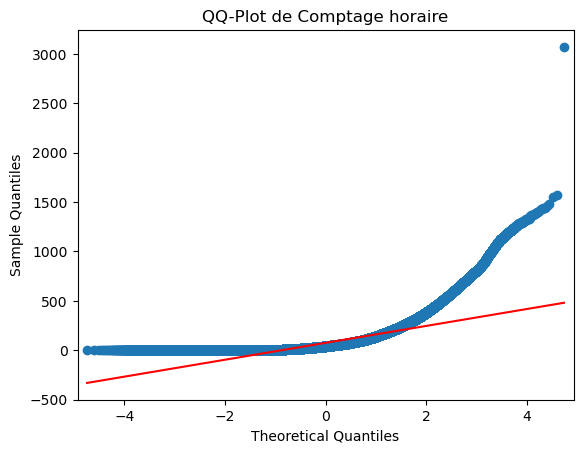


On peut se rendre compte que la distribution n'est pas normale.
Ceci peut s'expliquer par le fait que les données sont concentrées vers 0.


In [47]:
import statsmodels.api as sm

# Q-Q plot
sm.qqplot(df_clean["Comptage horaire"], line = "r")
plt.title("QQ-Plot de Comptage horaire")
plt.show()

print('''
On peut se rendre compte que la distribution n'est pas normale.
Ceci peut s'expliquer par le fait que les données sont concentrées vers 0.''')

In [ ]:
col_norm = ["Nom du compteur", "Jour", "Mois", "Année", "Heure", "Jour_semaine", "Week-end", "Jour férié", "Vacances scolaires"]

scaler = MinMaxScaler(feature_range=(0, 1))  # Normalisation entre 0 et 1
df_clean[col_norm] = scaler.fit_transform(df_clean[col_norm])

In [ ]:
df_clean.head()